<a href="https://colab.research.google.com/github/khadija267/Load-Time-Series-Forecasting/blob/main/Load_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Job Description
Create a model to forecast 15-min time-series electrical load data for a month.
We have 2 years of historical data to train the model, from 2021-present.
We need to create forecast for the next month.
The model also needs to take in temperature data for the location. We have the temperature data already.
We provide:
15 minute historical Time-series data for each of 3 sites
15 minute actual temperature data for the 3 sites



You provide:
15 minute load forecast for the next month


We provide:
15 minute historical Time-series data for each of 3 sites
15 minute actual temperature data for the 3 sites



You provide:
15 minute load forecast for the next month



Example. We have data for October 2021-March 2023. You provide a forecast for the month of April. (About 2976 data points, 15-minute)



There are 3 sites that we need to test this on now. Then we want the code to be able to run this in the future by our team.



We plan to use SARIMA, LSTM, etc. We specifically need to forecast one month, and would choose the method that produces the best results (on a different test month.)

In [222]:
#!pip install sia_ts_modelling
#! pip install pystan
#!pip install fbprophet
#! pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.8 MB/s eta 0:00:00


In [173]:
#import libraries
#from google.colab import drive
#drive.mount('/content/helper.py')

from helper import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pylab
import missingno as msno
import seaborn as sns
import datetime
import statsmodels.api as sm
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
import statsmodels.graphics.tsaplots as sgt
import requests
import json
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from itertools import product
#import fbprophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterGrid
%matplotlib inline
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## 1. Data Investigation and Preparation

In [174]:
load=pd.read_csv('lsc.csv')
temp = pd.read_csv('lsc_temp.csv')

'''
# Load data
data = pd.read_csv('data.csv', parse_dates=['datetime'], index_col='datetime')

# Resample data from minutes to days
resampled_data = data.resample('D').mean()

# Interpolate data to obtain minute-level values
interpolated_data = resampled_data.interpolate(method='linear', limit_direction='both')

# View minute-level data
minute_level_data = interpolated_data.resample('1min').ffill()
'''



"\n# Load data\ndata = pd.read_csv('data.csv', parse_dates=['datetime'], index_col='datetime')\n\n# Resample data from minutes to days\nresampled_data = data.resample('D').mean()\n\n# Interpolate data to obtain minute-level values\ninterpolated_data = resampled_data.interpolate(method='linear', limit_direction='both')\n\n# View minute-level data\nminute_level_data = interpolated_data.resample('1min').ffill()\n"

### 1.1 Data Investigation

In [175]:
load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40895 entries, 0 to 40894
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Datetime MST  40895 non-null  object 
 1   Load          40895 non-null  float64
dtypes: float64(1), object(1)
memory usage: 639.1+ KB


In [177]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13847 entries, 0 to 13846
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    13847 non-null  object 
 1   temp    13847 non-null  float64
dtypes: float64(1), object(1)
memory usage: 216.5+ KB


In [178]:
# check for the head
load.head()


,Datetime MST,Load
0,3/1/2022 0:15,85.38
1,3/1/2022 0:30,82.81
2,3/1/2022 0:45,81.88
3,3/1/2022 1:00,76.50
4,3/1/2022 1:15,76.75


Load data is represeted in 15 minutes

In [179]:

temp.head()


,time,temp
0,2021-10-01 01:00:00,26.1
1,2021-10-01 02:00:00,25.0
2,2021-10-01 03:00:00,24.4
3,2021-10-01 04:00:00,23.9
4,2021-10-01 05:00:00,23.9


Temperature data is represeted in hours

Check for duplicates


In [180]:
load.duplicated().any()

False

In [181]:
load[lsc_load.duplicated() ==True]

,Datetime MST,Load


In [182]:
temp.duplicated().any()

False

> No duplicated entries in the data

Check for outliers


In [185]:
# Calculate IQR
def IQR(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]

    # Count outliers
    num_outliers = len(outliers)
    print("Number of outliers:", num_outliers)


Number of outliers: 38


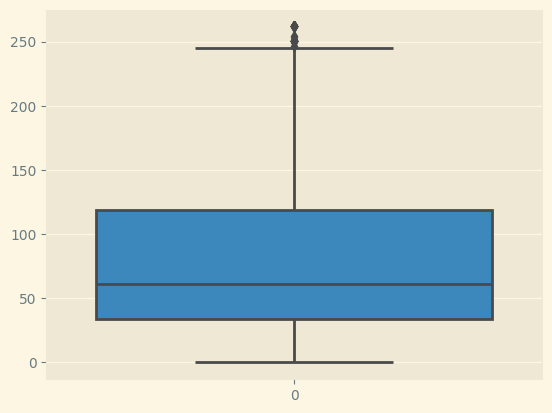

In [186]:
IQR(load.Load)
sns.boxplot(load.Load);


Number of outliers: 20


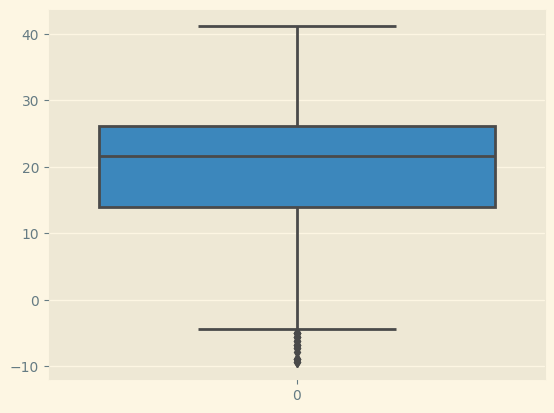

In [187]:
IQR(temp.temp)
sns.boxplot(temp.temp);

> There are some oulier points

Check for data discription


In [188]:
load.describe()

,Load
count,40895.000000
mean,80.324809
std,52.683940
min,0.000000
25%,34.250000
50%,61.130000
75%,118.855000
max,261.810000


In [189]:
temp.describe()

,temp
count,13847.000000
mean,20.163097
std,8.605824
min,-9.400000
25%,13.900000
50%,21.700000
75%,26.100000
max,41.100000


Ploting a QQ plot: <br>
To determine whether the data is distributed into a certain way.
How data can fit a normal distrubution

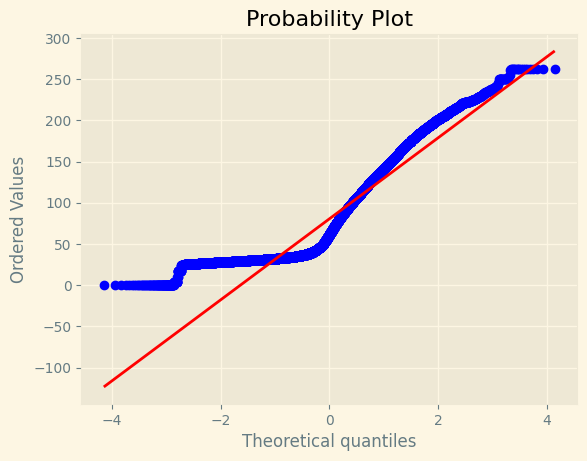

In [190]:
## Quantile Quarter plot (QQ plot)
scipy.stats.probplot(load.Load,plot=pylab)
pylab.show()


> According to the QQ plot above
- There are more values around [0-50]; Data is not normally distributed.

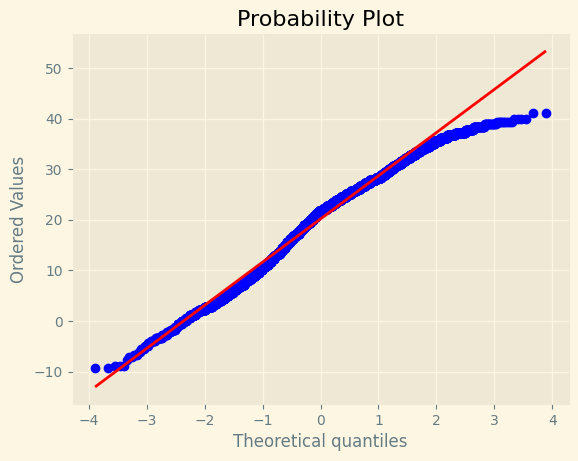

In [191]:
scipy.stats.probplot(temp.temp,plot=pylab)
pylab.show()


- There are more values around 40 Data is not normally distributed.

### 1.2 Data Preparation

Create Date time index

In [192]:
# convert the Datetime MST to datetime data type in utc timezone
load['Datetime MST']=pd.to_datetime(load['Datetime MST'],utc=True)
temp['time']=pd.to_datetime(temp['time'],utc=True)

In [193]:
load['Datetime MST'].describe()

count                         40895
unique                        40895
top       2022-03-01 00:15:00+00:00
freq                              1
first     2022-03-01 00:15:00+00:00
last      2023-04-30 23:45:00+00:00
Name: Datetime MST, dtype: object

In [194]:
temp['time'].describe()

count                         13847
unique                        13847
top       2021-10-01 01:00:00+00:00
freq                              1
first     2021-10-01 01:00:00+00:00
last      2023-04-30 23:00:00+00:00
Name: time, dtype: object

In [195]:
load.set_index('Datetime MST',inplace=True)
load.head()

,Load
Datetime MST,
2022-03-01 00:15:00+00:00,85.38
2022-03-01 00:30:00+00:00,82.81
2022-03-01 00:45:00+00:00,81.88
2022-03-01 01:00:00+00:00,76.50
2022-03-01 01:15:00+00:00,76.75


In [197]:
temp.set_index('time',inplace=True)
temp.head()

,temp
time,
2021-10-01 01:00:00+00:00,26.1
2021-10-01 02:00:00+00:00,25.0
2021-10-01 03:00:00+00:00,24.4
2021-10-01 04:00:00+00:00,23.9
2021-10-01 05:00:00+00:00,23.9


Setting the 15 minutes frequency to days

In [198]:
load = load.resample('D').mean()
temp = temp.resample('D').mean()

In [199]:
load.head()

,Load
Datetime MST,
2022-03-01 00:00:00+00:00,109.609158
2022-03-02 00:00:00+00:00,100.077083
2022-03-03 00:00:00+00:00,92.068229
2022-03-04 00:00:00+00:00,82.442396
2022-03-05 00:00:00+00:00,45.378750


In [134]:
#lsc_load=lsc_load.asfreq('15T')
#lsc_temp=lsc_temp.asfreq('15T')

Check for missing values

In [200]:
load.isna().sum()

Load    0
dtype: int64

In [201]:
temp.isna().sum()

temp    0
dtype: int64

In [202]:
#msno.matrix(lsc_temp);

Load Data: <br>
Now, there are no load periods that were not included in the original set.
We have double checked that we have no missings.
<br>
<br>
Temperature Data: <br>
There is missing data after getting the 15 minutes temperatuer data, that needs to filled

Fill the missings data in the tempertature by front filling, hence we set the same value for every 15 minutes in the hour

In [132]:
#temp = temp.fillna(method="ffill")

In [133]:
#temp.head()

,temp
time,
2021-10-01 01:00:00+00:00,26.1
2021-10-01 01:15:00+00:00,26.1
2021-10-01 01:30:00+00:00,26.1
2021-10-01 01:45:00+00:00,26.1
2021-10-01 02:00:00+00:00,25.0


Merge the dataset

In [203]:
df = load.merge(
    temp, left_index=True, right_index=True)
df.head()

,Load,temp
2022-03-01 00:00:00+00:00,109.609158,11.625000
2022-03-02 00:00:00+00:00,100.077083,13.650000
2022-03-03 00:00:00+00:00,92.068229,17.012500
2022-03-04 00:00:00+00:00,82.442396,17.641667
2022-03-05 00:00:00+00:00,45.378750,22.429167


### 1.3 Stationarity test

In [204]:
sts.adfuller(df.Load)

(-2.8864385099970193,
 0.04694789464807178,
 14,
 411,
 {'1%': -3.4463612216221775,
  '5%': -2.8685980017932917,
  '10%': -2.5705296947685605},
 3552.542518798829)

Load Data <br>
We reject the null hypothesis, hence there a stationarity in the data set (the previous 54 lags to the current lag have identical cov)

In [205]:
sts.adfuller(df.temp)

(-2.6801368302529545,
 0.07753898499577479,
 5,
 420,
 {'1%': -3.4460159927788574,
  '5%': -2.868446209372638,
  '10%': -2.570448781179138},
 1984.1162087111243)

Temp Data <br>
We Accept the null hypothesis, hence there a no stationarity in the data set (the previous 5 lags to the current lag don't have identical cov)

### 1.4 Seasonality Check
1. Additive

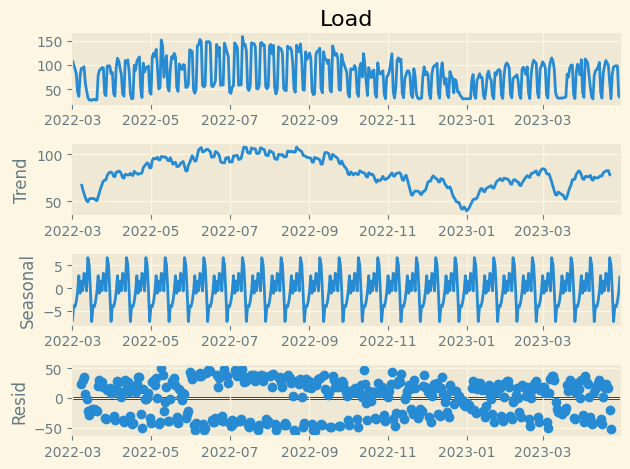

In [206]:
# test
df_additive_compose = sm.tsa.seasonal_decompose(df.Load,period=15, model="additive")
df_additive_compose.plot();

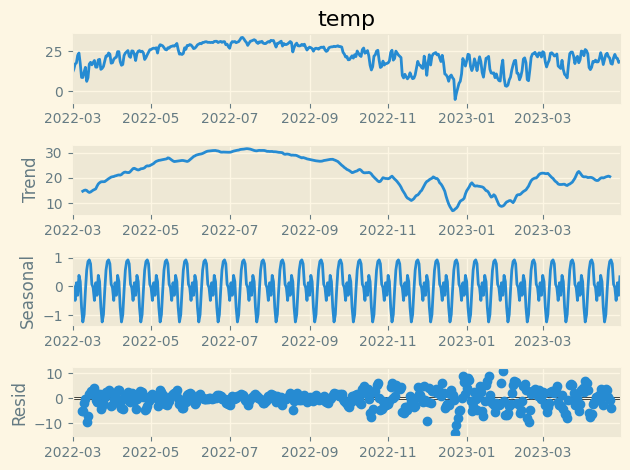

In [207]:
# test
df_additive_compose = sm.tsa.seasonal_decompose(df.temp,period=15, model="additive")
df_additive_compose.plot();

There is a cyclical pattern,hence a seasonality

> The residual is big hence the differences between true and predicted values for any period is significant

2. Multiplicative

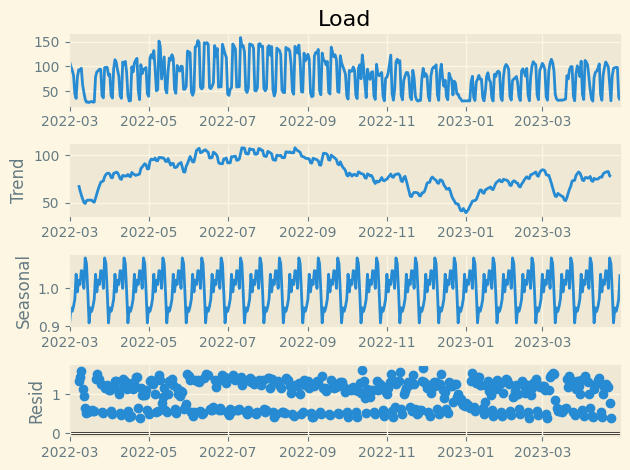

In [208]:
# test
df_additive_compose = sm.tsa.seasonal_decompose(df.Load,period=15, model="multiplicative")
df_additive_compose.plot();

### 1.5 ACF


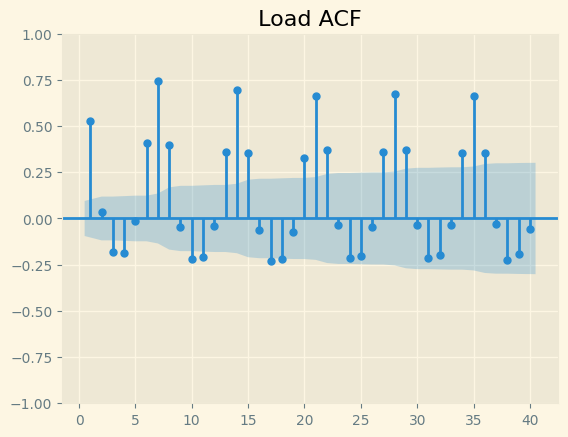

In [210]:
sgt.plot_acf(df.Load,lags=40,zero=False);
plt.title(" Load ACF ");

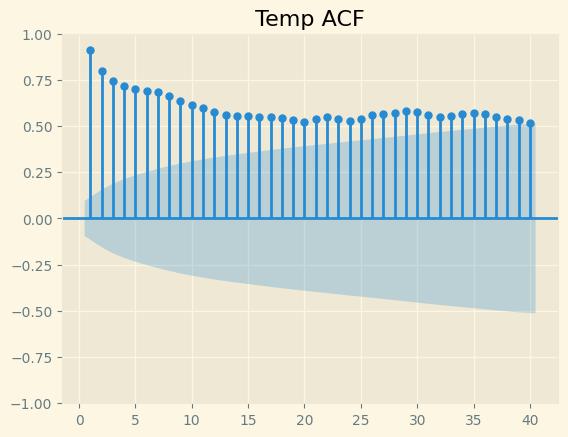

In [211]:
sgt.plot_acf(df.temp,lags=40,zero=False);
plt.title(" Temp ACF ");


- The significance graph (blue shade) is expanding, hence significance difference of higher lags is significantly different from zero

- We set the lags to 40, the autocorrelation starting from the very previous lag to the 40th lag is decreasing especially in the load data , hence moving away from the current lag and taking these vales for prediction is useful.

### 1.6 PACF <br>
Direct to the current lag , used to detect the number of lags used in the modeling

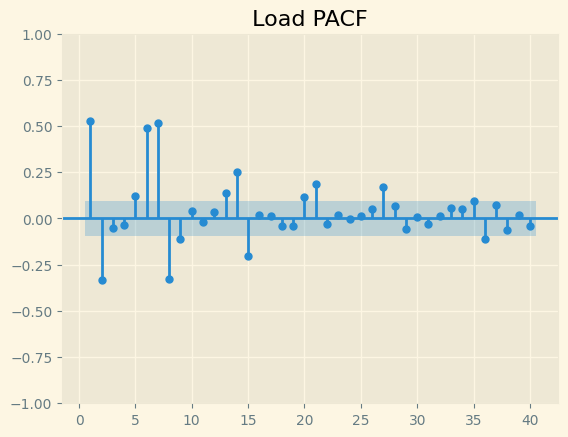

In [212]:
# using the order of least squares method
sgt.plot_pacf(df.Load,lags=40,zero=False,method=('ols'));
plt.title(" Load PACF ");

The are lags starting from 6 lags ago resulted in lower values

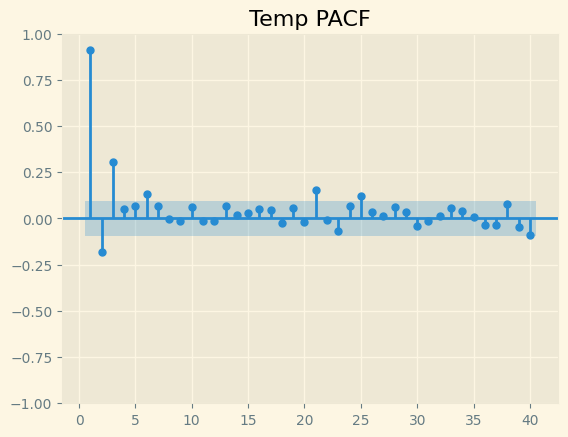

In [213]:
sgt.plot_pacf(df.temp,lags=40,zero=False,method=('ols'));
plt.title(" Temp PACF ");

The are lags in the 5th, 9th lags ago resulted in significantly lower values.


- Overall, the blue curve is vanished, and that resembles all coefficients attached to these lags should be zero( lags to be omitted)
- number of lags used is 25 for temperature and 7 for the load data

## 2. Modeling


We need to construct a cutoff to split the data set at. <br>
We set the training set size of 80%



Text(0.5, 1.0, 'Load Vs Temp values')

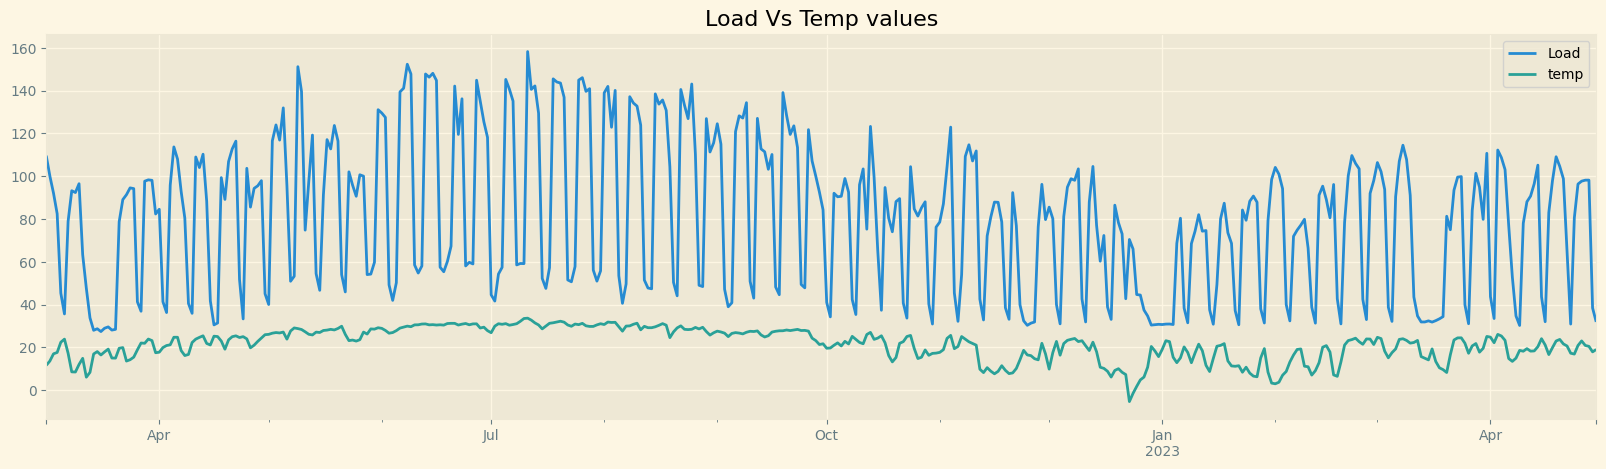

In [214]:
plt.figure(figsize=(20,5))
df['Load'].plot();
df['temp'].plot();
plt.legend()
plt.title( "Load Vs Temp values")

In [215]:
size=int(len(df)*0.93)
train=df[:size]
test=df[size:]

In [216]:
print("Training set ends at")
print(train.tail(1))
print("\nTesting set starts at")
print(test.head(1))


Training set ends at
                                 Load    temp
2023-03-31 00:00:00+00:00  110.697812  25.125

Testing set starts at
                                Load     temp
2023-04-01 00:00:00+00:00  43.726354  24.8125


The cutoff period is 2023-04-01

### 2.1 AR without Temperature




In [218]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(train.Load, lags=7, trend='n',seasonal=True,).fit()
print(model.summary())
forecasts = model.forecast(len(test)).tolist()
test_values = test.Load.values.tolist()
difference=[]
for i in range(len(forecasts)):
  difference.append(forecasts[i] - test_values[i])


                            AutoReg Model Results                             
Dep. Variable:                   Load   No. Observations:                  396
Model:               Seas. AutoReg(7)   Log Likelihood               -1690.555
Method:               Conditional MLE   S.D. of innovations             18.671
Date:                Mon, 26 Jun 2023   AIC                           3411.110
Time:                        22:04:33   BIC                           3470.564
Sample:                    03-08-2022   HQIC                          3434.680
                         - 03-31-2023                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s(1,7)        17.8148      5.771      3.087      0.002       6.505      29.125
s(2,7)        12.9304      5.738      2.253      0.024       1.683      24.177
s(3,7)        21.3441      5.727      3.727      0.0

Having p-value =0 for c and the ar.L1 till ar.L7 resembles that they are significant different from zero. Having non zeros CI values , then the coefficients are significance.

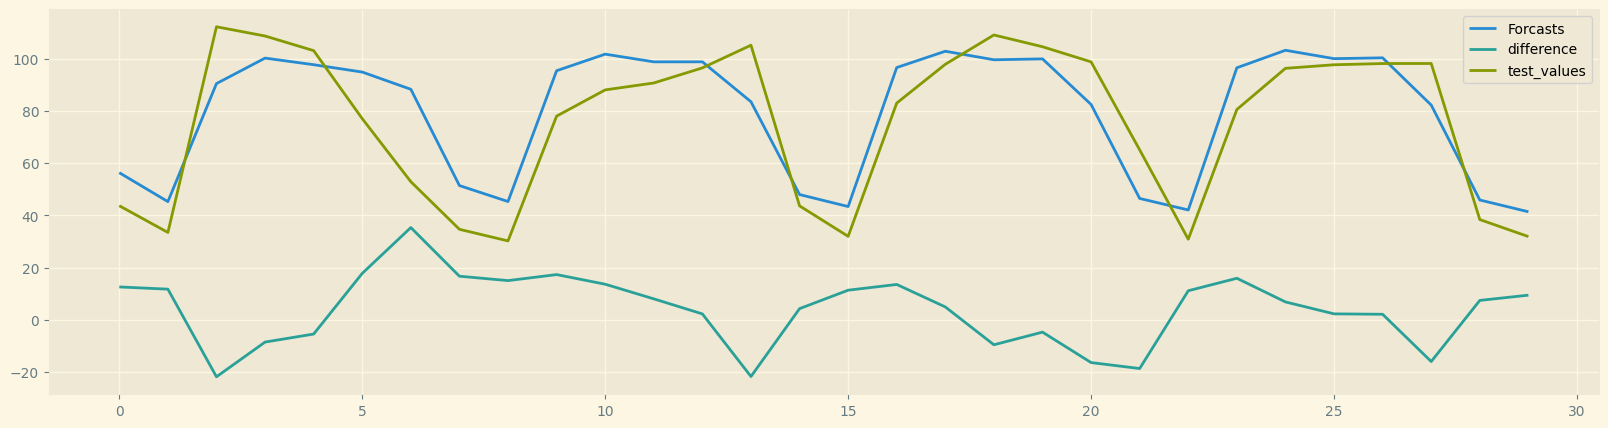

In [219]:
plt.figure(figsize=(20,5))
plt.plot(forecasts)
plt.plot(difference)
plt.plot(test_values)
plt.legend(['Forcasts','difference','test_values']);

### 2.2 AR with Temperature




In [220]:
from statsmodels.tsa.api import VAR
model = VAR(train)
model.select_order(25)
results = model.fit(maxlags=25, ic='aic')
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 26, Jun, 2023
Time:                     22:05:10
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    8.68793
Nobs:                     381.000    HQIC:                   8.30089
Log likelihood:          -2552.05    FPE:                    3124.53
AIC:                      8.04632    Det(Omega_mle):         2672.02
--------------------------------------------------------------------
Results for equation Load
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           21.164734         5.252309            4.030           0.000
L1.Load          0.447102         0.052255            8.556           0.000
L1.temp          0.463291         0.354672            1.306           0.191
L2.Lo

In [ ]:
results.forecast(test.values,len(test))

array([[44.82761219, 28.89277288],
       [47.66521141, 28.87324152],
       [49.61652126, 28.87017203],
       ...,
       [82.20636784, 22.32596047],
       [82.20636784, 22.32596047],
       [82.20636784, 22.32596047]])

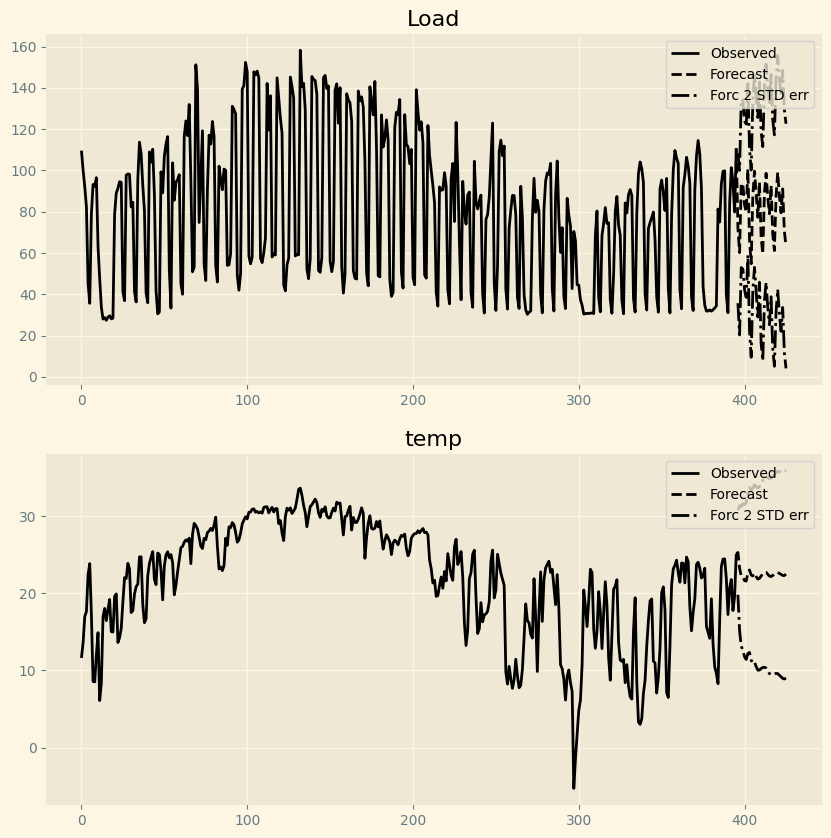

In [221]:
from numpy import savetxt
#savetxt('forcasting.csv', results.forecast(test.values,test.shape[0]), delimiter=',')
results.plot_forecast(test.shape[0]);

AR model is simple to capture any pattern in our data, we won't try MA and we are going to try ARIMA in the next cells

### 2.3 LLR Test <br>
Showing if models are significanlty different or not


In [ ]:
'''
# create lagged variables for load and temperature
p = 25 # order of the AR model
q = 7 # number of lags of temperature to include
Y = df.Load[p:]
X = np.column_stack([df.Load.shift(i)[p:] for i in range(1, p+1)] + [df.temp.shift(i)[p:] for i in range(1, q+1)])
X = sm.add_constant(X)

# fit the AR model using OLS regression
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

# forecast future values of the load given future values of temperature
forecast_periods = 12 # number of periods to forecast
forecast_X = np.column_stack([df.Load[-p+i:] for i in range(1, p+1)] + [df.temp[-q+i:] for i in range(1, q+1)])
forecast_X = sm.add_constant(forecast_X)
forecast_load = results.predict(forecast_X)
'''


'\n# create lagged variables for load and temperature\np = 25 # order of the AR model\nq = 7 # number of lags of temperature to include\nY = df.Load[p:]\nX = np.column_stack([df.Load.shift(i)[p:] for i in range(1, p+1)] + [df.temp.shift(i)[p:] for i in range(1, q+1)])\nX = sm.add_constant(X)\n\n# fit the AR model using OLS regression\nmodel = sm.OLS(Y, X)\nresults = model.fit()\nprint(results.summary())\n\n# forecast future values of the load given future values of temperature\nforecast_periods = 12 # number of periods to forecast\nforecast_X = np.column_stack([df.Load[-p+i:] for i in range(1, p+1)] + [df.temp[-q+i:] for i in range(1, q+1)])\nforecast_X = sm.add_constant(forecast_X)\nforecast_load = results.predict(forecast_X)\n'

In [ ]:
'''
plt.figure(figsize=(20,5))
plt.plot(df.Load)
plt.plot(np.arange(len(df.Load), len(df.Load)+forecast_periods), forecast_load)
plt.show()
'''

### 2.4 Auto ARIMA without Temprature



In [ ]:
#!pip install pmdarima


In [291]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['Load'],trace=True,stepwise=True
,suppress_warnings=True,seasonal=True,stationary=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3997.319, Time=3.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4213.237, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4215.081, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4214.892, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4211.249, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4060.734, Time=1.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4028.567, Time=1.31 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.03 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3900.177, Time=2.36 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4052.668, Time=1.21 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3885.191, Time=3.96 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3888.726, Time=2.56 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.94 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3879.739, Time=1.38 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4

In [292]:
from statsmodels.tsa.arima_model import ARIMA
model=sm.tsa.arima.ARIMA(train['Load'],order=(2,1,5))
model=model.fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Load   No. Observations:                  396
Model:                 ARIMA(2, 1, 5)   Log Likelihood               -1797.293
Date:                Mon, 26 Jun 2023   AIC                           3610.586
Time:                        22:26:48   BIC                           3642.417
Sample:                    03-01-2022   HQIC                          3623.197
                         - 03-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2458      0.005    250.459      0.000       1.236       1.256
ar.L2         -0.9963      0.005   -216.164      0.000      -1.005      -0.987
ma.L1         -1.8607      0.055    -33.637      0.000      -1.969      -1.752
ma.L2          1.4360      0.126     11.429      0.000       1.190       1.682
ma.L3         -0.1638      0.148     -1.109      0.267      -0.453       0.126
ma.L4         -0.3960      0.106     -3.734      0.000      -0.604      -0.188
ma.L5          0.1061      0.047      2.236      0.025       0.013       0.199
sigma2       508.1008     42.047     12.084      0.000     425.691     590.511
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 6.35
Prob(Q):                              0.90   Prob(JB):                         0.04
Heteroskedasticity (H):               0.71   Skew:                             0.29
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Model prediction on the testing set

<Axes: >

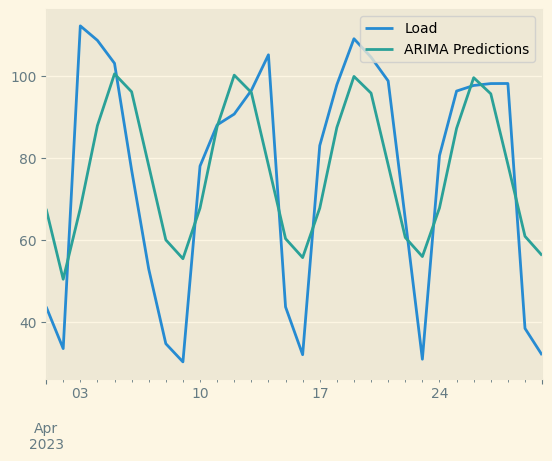

In [293]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
test['Load'].plot(legend=True)
pred.plot(legend=True)


Model is overfitting

In [294]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['Load'].mean()
rmse=sqrt(mean_squared_error(pred,test['Load']))
print(rmse)

18.813028266733834


### 2.5 Auto ARIMA with Temprature



In [295]:
# Define the exogenous variable
exog_train = train[['temp']]
exog_test = test[['temp']]

In [ ]:
'''
stepwise_fit = auto_arima(train['Load'],exog_train, trace=True,stepwise=True,max_p=25,max_q=25
,suppress_warnings=True)
'''

In [299]:
stepwise_fit = auto_arima(train['Load'],exog_train, trace=True,stepwise=True
,suppress_warnings=True,seasonal=True,stationary=False)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3643.529, Time=1.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3894.754, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3808.904, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3774.374, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3951.773, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3763.934, Time=1.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3725.976, Time=1.12 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3619.790, Time=1.86 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3739.453, Time=1.01 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=3744.862, Time=1.20 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=3735.574, Time=0.82 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=3712.324, Time=1.21 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=3

In [229]:
model=sm.tsa.arima.ARIMA(train['Load'], order=(3,0,2), exog=exog_train)
model=model.fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Load   No. Observations:                  396
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -1854.932
Date:                Mon, 26 Jun 2023   AIC                           3725.863
Time:                        22:07:55   BIC                           3757.715
Sample:                    03-01-2022   HQIC                          3738.482
                         - 03-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.3383      4.147      9.245      0.000      30.210      46.466
temp           1.9432      0.170     11.406      0.000       1.609       2.277
ar.L1          0.0004      0.093      0.004      0.997      -0.181       0.182
ar.L2          0.3745      0.071      5.246      0.000       0.235       0.514
ar.L3         -0.5406      0.068     -7.990      0.000      -0.673      -0.408
ma.L1          0.5597      0.109      5.127      0.000       0.346       0.774
ma.L2         -0.4316      0.107     -4.031      0.000      -0.642      -0.222
sigma2       683.3668     67.803     10.079      0.000     550.476     816.258
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 6.95
Prob(Q):                              0.61   Prob(JB):                         0.03
Heteroskedasticity (H):               0.77   Skew:                             0.14
Prob(H) (two-sided):                  0.14   Kurtosis:                         2.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Model prediction on the testing set

<Axes: >

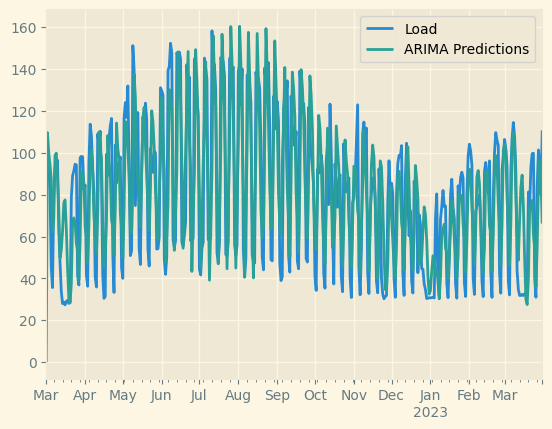

In [296]:
start=0
end=len(train)-1
pred=model.predict(start=start,end=end,typ='levels',exog=exog_train).rename('ARIMA Predictions')
train['Load'].plot(legend=True)
pred.plot(legend=True)

<Axes: >

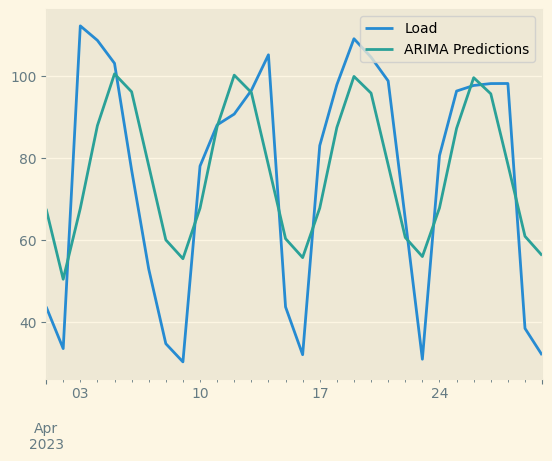

In [297]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels',exog=exog_test).rename('ARIMA Predictions')
test['Load'].plot(legend=True)
pred.plot(legend=True)

Model is overfitting

In [298]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['Load'].mean()
rmse=sqrt(mean_squared_error(pred,test['Load']))
print(rmse)

18.813028266733834


In [ ]:
'''
model = pm.auto_arima(final_df['demand'],
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',
                           suppress_warnings=True,
                      stepwise=True, trace=True)
'''

### 2.6 Exponential Smoothing

As along with previous analysis done before, data had no seasonlaity or trend, hence we can use the Exponential Smoothing Method

In [140]:
test.isna().sum()

Load    0
temp    0
Pred    0
dtype: int64

In [300]:



# Define the parameter grid for tuning
params = {
    'trend': ['add', 'mul', None],
    'seasonal': ['add', 'mul', None],
    'seasonal_periods': [24 * 4],
}

# Generate all combinations of parameters
param_combinations = list(product(*params.values()))

# Train and evaluate models for each parameter combination
results = []
for p in param_combinations:
    # Fit model
    model = ExponentialSmoothing(train['Load'], trend=p[0], seasonal=p[1], seasonal_periods=p[2])
    fitted_model = model.fit()

    # Make predictions
    preds = fitted_model.forecast(len(test))

    # Evaluate model
    mae = mean_absolute_error(test['Load'], preds)
    results.append((p, mae))

# Find the best parameter combination
best_params, best_mae = min(results, key=lambda x: x[1])
print('Best MAE:', best_mae)
print('Best parameters:', dict(zip(params.keys(), best_params)))



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Best MAE: 24.863047972868536
Best parameters: {'trend': 'mul', 'seasonal': None, 'seasonal_periods': 96}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [301]:
# Train model with best parameters and make predictions
es_model = ExponentialSmoothing(train['Load'], trend=best_params[0], seasonal=best_params[1], seasonal_periods=best_params[2])
fitted_best_model = es_model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [302]:
# Generate future predictions
start_date = pd.to_datetime('2023-04-01')
end_date = pd.to_datetime('2023-05-1')
future_index = pd.date_range(start=start_date, end=end_date, freq='15T')
future_preds = fitted_model.forecast(len(future_index))

# Create dataframe of future predictions
future_df = pd.DataFrame({'value': future_preds}, index=future_index)

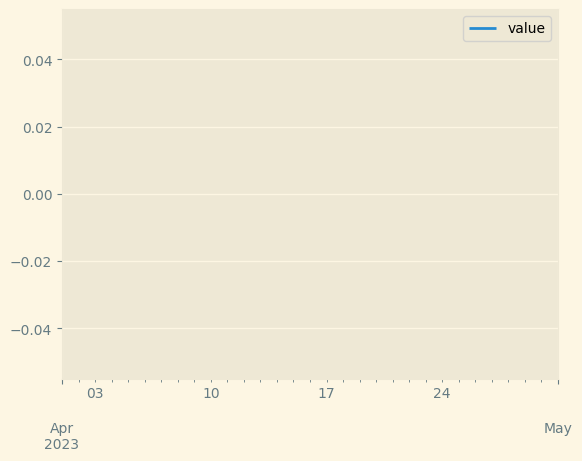

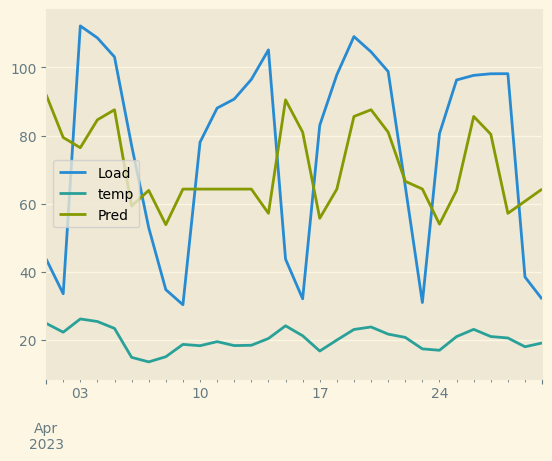

In [303]:
future_df.value.plot(legend=True);
test.plot(legend=True);

### 2.7 RF Regression

In [306]:

# Define the input and output variables
X_train = train.drop(['Load'], axis=1)
y_train = train['Load']
X_test = test.drop(['Load'], axis=1)
y_test = test['Load']

In [307]:

# Define the hyperparameters to search
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Choose an evaluation metric
scoring_metric = mean_absolute_error

# Choose a search algorithm
search_algorithm = GridSearchCV(RandomForestRegressor(random_state=42), params, cv=5, n_jobs=-1, scoring=scoring_metric)

# Train the Random Forest model with different hyperparameters
search_algorithm.fit(X_train, y_train)

# Select the best hyperparameters
best_params = search_algorithm.best_params_
print('Best hyperparameters:', best_params)


Best hyperparameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

In [308]:
# Evaluate the performance of the Random Forest model on the test set
y_pred = search_algorithm.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error on test set:', mae)

Mean Absolute Error on test set: 29.668658676529322


In [309]:

# Make predictions for the future temperature values using the best hyperparameters
model = RandomForestRegressor(max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100)
model.fit(X_train, y_train)


RandomForestRegressor(max_depth=5)

Mean Absolute Error: 15.866930669825408


<ipython-input-310-44506757f2ad>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Pred']=y_pred


<Axes: >

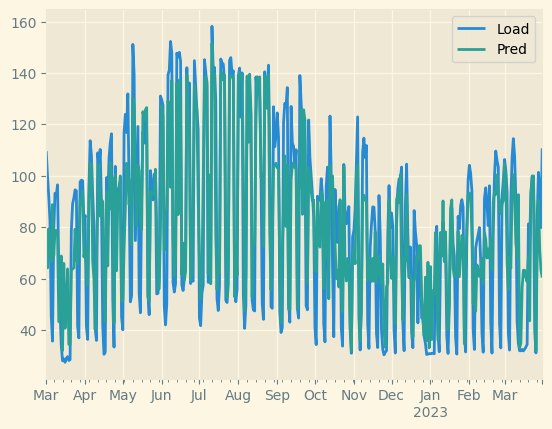

In [310]:
# Predict on the testing set# Predict on the testing set
y_pred = model.predict(X_train)

# Calculate the mean squared error
mse = mean_absolute_error(y_train, y_pred)
print('Mean Absolute Error:', mse)
temp=train
temp['Pred']=y_pred
train['Load'].plot(legend=True)
temp['Pred'].plot(legend=True)

Mean Absolute Error: 30.071203470690477


<ipython-input-311-8f7c5447a805>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Pred']=y_pred


<Axes: >

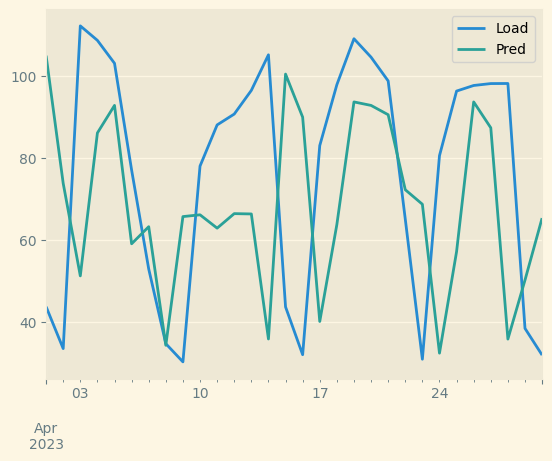

In [311]:
# Predict on the testing set# Predict on the testing set
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mse)
temp=test
temp['Pred']=y_pred
test['Load'].plot(legend=True)
temp['Pred'].plot(legend=True)

In [312]:
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error on test set:', mae)

Mean Absolute Error on test set: 30.071203470690477


### 2.8 Prophet

In [313]:

# Define the grid of hyperparameters to search
params_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'changepoint_range': [0.8, 0.9, 1.0]
}

# Define the evaluation metric
scoring_metric = mean_absolute_error

# Perform grid search to find the best hyperparameters
best_score = float('inf')
best_params = None
for params in ParameterGrid(params_grid):
    model = Prophet(seasonality_mode=params['seasonality_mode'],
                    changepoint_prior_scale=params['changepoint_prior_scale'],
                    changepoint_range=params['changepoint_range'])
    model.add_regressor('temp')
    model.fit(train)
    future = model.make_future_dataframe(periods=24, freq='H')
    future['temp'] = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
    forecast = model.predict(future)
    score = scoring_metric(train['load'], forecast['yhat'][:-24])
    if score < best_score:
        best_score = score
        best_params = params

# Print the best hyperparameters and the corresponding mean absolute error
print('Best hyperparameters:', best_params)
print('Best mean absolute error:', best_score)

NameError: ignored

### 2.9 Gradient Boosting

In [314]:
from sklearn.model_selection import GridSearchCV

# Create a Gradient Boosting Regressor object
model = GradientBoostingRegressor()

# Define the grid of hyperparameters to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define the evaluation metric
scoring_metric = 'neg_mean_absolute_error'

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scoring_metric)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding mean squared error
print('Best hyperparameters:', grid_search.best_params_)
print('Best mean squared error:', -grid_search.best_score_)

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Best mean squared error: 20.455868517961648


In [315]:


# Create a Gradient Boosting Regressor object
model = GradientBoostingRegressor(learning_rate=0.1,max_depth=3, min_samples_leaf= 4, min_samples_split= 2, n_estimators=50)

# Train the model on the training set
model.fit(X_train, y_train)




GradientBoostingRegressor(min_samples_leaf=4, n_estimators=50)

Mean Absolute Error: 16.479043864966204


<ipython-input-316-44506757f2ad>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Pred']=y_pred


<Axes: >

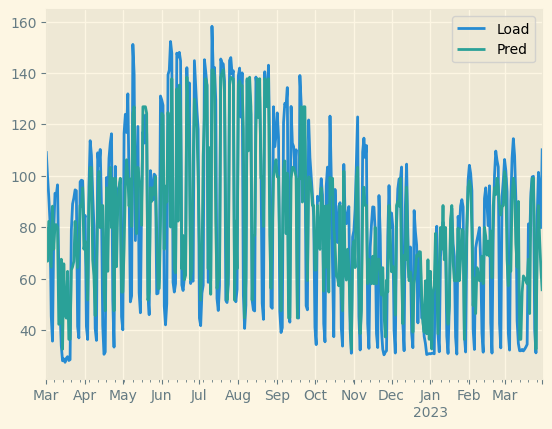

In [316]:
# Predict on the testing set# Predict on the testing set
y_pred = model.predict(X_train)

# Calculate the mean squared error
mse = mean_absolute_error(y_train, y_pred)
print('Mean Absolute Error:', mse)
temp=train
temp['Pred']=y_pred
train['Load'].plot(legend=True)
temp['Pred'].plot(legend=True)

Mean Absolute Error: 29.67976048225865


<ipython-input-317-8f7c5447a805>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Pred']=y_pred


<Axes: >

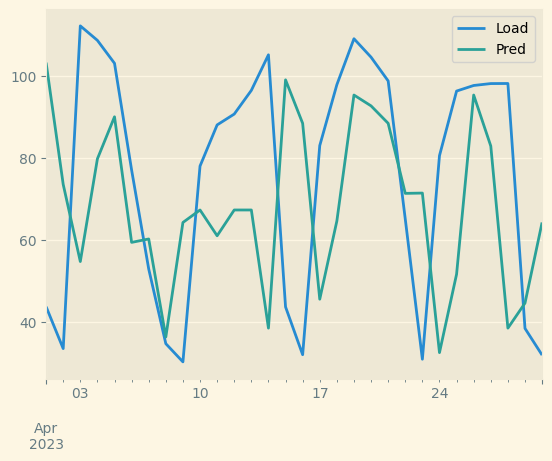

In [317]:
# Predict on the testing set# Predict on the testing set
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mse)
temp=test
temp['Pred']=y_pred
test['Load'].plot(legend=True)
temp['Pred'].plot(legend=True)

In [318]:
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error on test set:', mae)

Mean Absolute Error on test set: 29.67976048225865


### 3. LSTM with Temperature

Data Scaling

In [247]:
X, y = df.drop(columns=['Load']), df.Load.values
X.shape, y.shape

((426, 1), (426,))

In [248]:

mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X.values.reshape(-1, 1))
y_trans = mm.fit_transform(y.reshape(-1, 1))

 We want to feed in 7 samples, up to the current lag, and predict the next 5 time step values

In [357]:
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 25, 10)
print(X_ss.shape, y_mm.shape)

(393, 25, 1) (393, 10)


In [358]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)

X_train = X_ss[:-30]
X_test = X_ss[-30:]

y_train = y_mm[:-30]
y_test = y_mm[-30:]

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)


Training Shape: (363, 25, 1) (363, 10)
Testing Shape: (30, 25, 1) (30, 10)


In [359]:
# convert to pytorch tensors
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

In [360]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,
                                      (X_train_tensors.shape[0], 25,
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,
                                     (X_test_tensors.shape[0], 25,
                                      X_test_tensors.shape[2]))

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape: torch.Size([363, 25, 1]) torch.Size([363, 10])
Testing Shape: torch.Size([30, 25, 1]) torch.Size([30, 10])


The size of the input is then (𝑁,𝐿,𝐻_𝑖𝑛), where 𝑁 is the batch size, 𝐿 is the sequence length,
 and 𝐻_𝑖𝑛 is the input size (i.e. the number of features).
the rows of the dataframe in the first dimension,
 followed by the length of the dataframe in the next dimension
 (representing the length of the input sequence),
 and finally the features (of which we have four) in the final dimension.

take the 100 previous predictors up to the current time-step, and predict 50 time-steps into the future.
we have 150 batch feature samples, each consisting of 100 time-steps and the temperature feature predictors. In the targets for the test set, we again have 150 batch samples, each consisting of an array of length 50 of scalar outputs.

Model Construction

In [361]:

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()

    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 25 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch,
                                                                      loss.item(),
                                                                      test_loss.item()))


In [362]:
n_epochs = 1000 # 1000 epochs
learning_rate = 0.0001 # 0.001 lr

input_size = 1 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 10 # number of output classes

lstm = LSTM(num_classes,
              input_size,
              hidden_size,
              num_layers)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [363]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.29788, test loss: 0.23690
Epoch: 25, train loss: 0.24074, test loss: 0.18460
Epoch: 50, train loss: 0.19482, test loss: 0.14337
Epoch: 75, train loss: 0.15942, test loss: 0.11228
Epoch: 100, train loss: 0.13288, test loss: 0.08961
Epoch: 125, train loss: 0.11352, test loss: 0.07367
Epoch: 150, train loss: 0.09979, test loss: 0.06291
Epoch: 175, train loss: 0.09033, test loss: 0.05598
Epoch: 200, train loss: 0.08401, test loss: 0.05178
Epoch: 225, train loss: 0.07990, test loss: 0.04940
Epoch: 250, train loss: 0.07729, test loss: 0.04820
Epoch: 275, train loss: 0.07566, test loss: 0.04769
Epoch: 300, train loss: 0.07464, test loss: 0.04757
Epoch: 325, train loss: 0.07398, test loss: 0.04763
Epoch: 350, train loss: 0.07353, test loss: 0.04775
Epoch: 375, train loss: 0.07319, test loss: 0.04788
Epoch: 400, train loss: 0.07292, test loss: 0.04800
Epoch: 425, train loss: 0.07268, test loss: 0.04811
Epoch: 450, train loss: 0.07244, test loss: 0.04821
Epoch: 475, train

In [364]:
df_X_ss = ss.transform(df.drop(columns=['Load'])) # old transformers
df_y_mm = mm.transform(df.Load.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 50, 10)
# converting to tensors
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 50, df_X_ss.shape[2]))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [365]:
train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()
data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

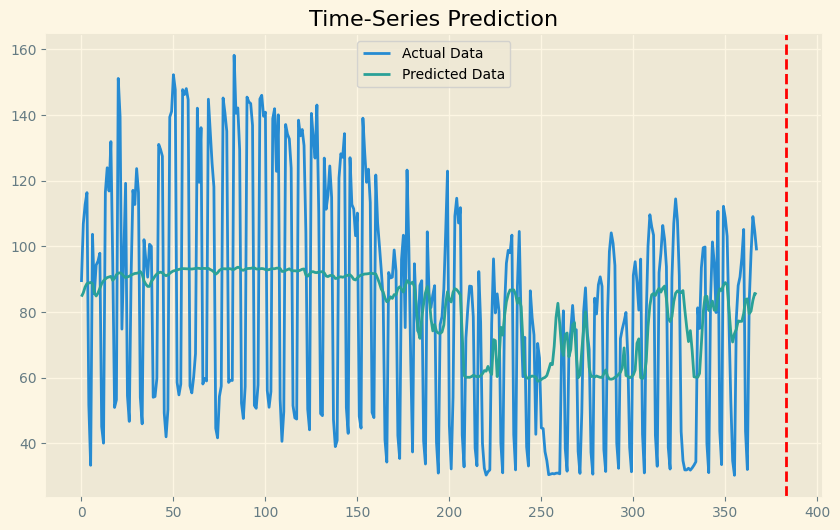

In [366]:
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show()

In [346]:
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error on test set:', mae)

Mean Absolute Error on test set: 67.9651816537112
